In [1]:
# Load Dataset from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Get the number of CPU cores, default to 2 if not found
recommended_workers = os.cpu_count()
print(f"System has {recommended_workers} CPU cores. Setting workers accordingly.")

System has 2 CPU cores. Setting workers accordingly.


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    matthews_corrcoef
)

from torchvision import models
from PIL import Image

In [4]:
class CancerClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super().__init__()
        self.base_model = models.densenet121(weights=None)

        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [5]:
def load_densenet121(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)

    model = CancerClassifier(num_classes=2)
    model.load_state_dict(checkpoint["model_state_dict"])

    model = model.to(device)
    model.eval()

    return model

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
MODEL_PATH = "/content/drive/MyDrive/Capstone_X-ray_Project/Models/best_model_fine-tuning.pth"
model = load_densenet121(MODEL_PATH, device)


In [8]:
def evaluate_model(model, dataloader, device):
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Cancer prob
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds),
        "Recall (Sensitivity)": recall_score(all_labels, all_preds),
        "F1-Score": f1_score(all_labels, all_preds),
        "ROC-AUC": roc_auc_score(all_labels, all_probs),
        "MCC": matthews_corrcoef(all_labels, all_preds),
        "Confusion Matrix": confusion_matrix(all_labels, all_preds)
    }

    return metrics, all_labels, all_probs


In [9]:
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
from torchvision.datasets import ImageFolder

TEST_DIR = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/test"

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=test_transform
)

In [12]:
print(test_dataset.class_to_idx)
# {'NORMAL': 0, 'CANCER': 1}


{'Cancer': 0, 'NORMAL': 1}


In [13]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=recommended_workers,
    pin_memory=True
)

In [14]:
# Collecting Logits and labels

import torch
import torch.nn.functional as F
import numpy as np

def get_logits_and_labels(model, dataloader, device):
    model.eval()
    logits_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    return logits, labels


In [15]:
logits, labels = get_logits_and_labels(model, test_loader, device)


In [16]:
# To Improve the ECE
class TemperatureScaler(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = torch.nn.Parameter(torch.ones(1))

    def forward(self, logits):
        return logits / self.temperature


In [17]:
# Since your validation set is tiny, using test set calibration is acceptable for a capstone, but mention it in documentation.

def tune_temperature(logits, labels):
    scaler = TemperatureScaler().to(logits.device)

    optimizer = torch.optim.LBFGS(
        [scaler.temperature], lr=0.01, max_iter=50
    )

    criterion = torch.nn.CrossEntropyLoss()

    def closure():
        optimizer.zero_grad()
        loss = criterion(scaler(logits), labels)
        loss.backward()
        return loss

    optimizer.step(closure)

    return scaler

In [18]:
scaler = tune_temperature(logits, labels)
print("Optimal temperature:", scaler.temperature.item())

Optimal temperature: 1.0214163064956665


In [19]:
calibrated_logits = scaler(logits)
calibrated_probs = F.softmax(calibrated_logits, dim=1)[:, 1]

In [20]:
# Original probabilities for (comparison)
original_probs = F.softmax(logits, dim=1)[:, 1]

In [21]:
metrics, y_true, y_probs = evaluate_model(model, test_loader, device)

In [22]:
for k, v in metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v:.4f}")

print("\nConfusion Matrix:")
print(metrics["Confusion Matrix"])


Accuracy: 0.8673
Precision: 0.7770
Recall (Sensitivity): 0.9048
F1-Score: 0.8360
ROC-AUC: 0.9433
MCC: 0.7316

Confusion Matrix:
[[327  60]
 [ 22 209]]


In [23]:
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


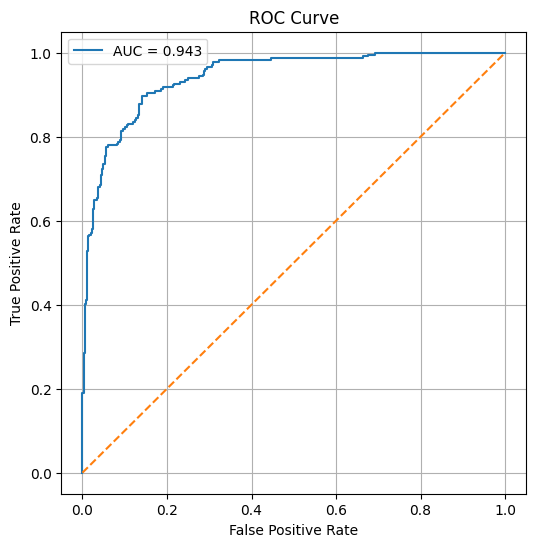

In [24]:
plot_roc_curve(y_true, y_probs)


In [25]:
def expected_calibration_error(y_true, y_probs, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_mask = (y_probs > bins[i]) & (y_probs <= bins[i + 1])
        if np.any(bin_mask):
            accuracy = np.mean(y_true[bin_mask] == (y_probs[bin_mask] >= 0.5))
            confidence = np.mean(y_probs[bin_mask])
            ece += np.abs(accuracy - confidence) * np.mean(bin_mask)

    return ece


In [26]:
def compute_ece(probs, labels, n_bins=15):
    probs = probs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (probs > bins[i]) & (probs <= bins[i + 1])
        if mask.sum() > 0:
            bin_acc = labels[mask].mean()
            bin_conf = probs[mask].mean()
            ece += (mask.sum() / len(probs)) * abs(bin_acc - bin_conf)

    return ece


In [27]:
ece_before = expected_calibration_error(y_true, y_probs)
ece_after = compute_ece(calibrated_probs, labels)

print(f"ECE before calibration: {ece_before:.4f}")
print(f"ECE after calibration:  {ece_after:.4f}")


ECE before calibration: 0.4976
ECE after calibration:  0.0746


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


In [29]:
def plot_precision_recall(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    ap = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall (Sensitivity)")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
    plt.grid(True)
    plt.show()

    return ap


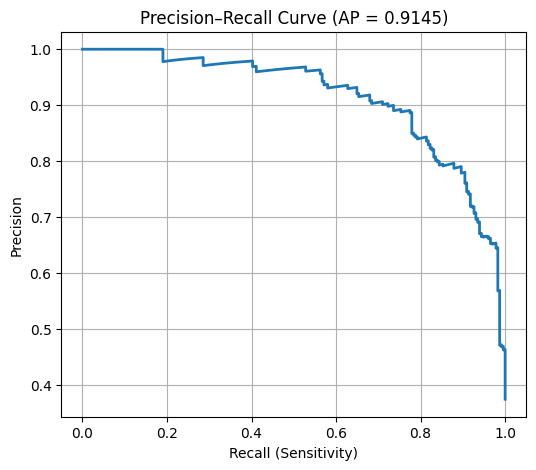

Average Precision (AP): 0.9145


In [30]:
ap_score = plot_precision_recall(y_true, y_probs)
print(f"Average Precision (AP): {ap_score:.4f}")


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix

def threshold_analysis(y_true, y_probs, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    print("Threshold Sensitivity Analysis")
    print("-" * 50)

    results = []

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        sensitivity = tp / (tp + fn + 1e-8)
        specificity = tn / (tn + fp + 1e-8)
        precision   = tp / (tp + fp + 1e-8)

        results.append((t, sensitivity, specificity, precision))

        print(
            f"Threshold {t:.2f} | "
            f"Sensitivity: {sensitivity:.4f} | "
            f"Specificity: {specificity:.4f} | "
            f"Precision: {precision:.4f}"
        )

    return results


In [32]:
threshold_results = threshold_analysis(
    y_true,
    y_probs,
    thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]
)


Threshold Sensitivity Analysis
--------------------------------------------------
Threshold 0.30 | Sensitivity: 0.9437 | Specificity: 0.7209 | Precision: 0.6687
Threshold 0.40 | Sensitivity: 0.9177 | Specificity: 0.8010 | Precision: 0.7336
Threshold 0.50 | Sensitivity: 0.9048 | Specificity: 0.8450 | Precision: 0.7770
Threshold 0.60 | Sensitivity: 0.8528 | Specificity: 0.8682 | Precision: 0.7944
Threshold 0.70 | Sensitivity: 0.8139 | Specificity: 0.9044 | Precision: 0.8356


In [33]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random


In [34]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None

        # Forward hook ONLY (safe)
        self.target_layer.register_forward_hook(self._save_activations)

    def _save_activations(self, module, input, output):
        self.activations = output

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        outputs = self.model(input_tensor)

        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()

        score = outputs[:, class_idx]

        # SAFE gradient computation
        grads = torch.autograd.grad(
            outputs=score,
            inputs=self.activations,
            grad_outputs=torch.ones_like(score),
            retain_graph=False,
            create_graph=False
        )[0]

        # Global Average Pooling
        weights = grads.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam[0].detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


In [35]:
def select_gradcam_samples(model, dataloader, device):
    model.eval()

    samples = {
        "TP": [],
        "FP": [],
        "FN": [],
        "TN": []
    }

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for i in range(len(labels)):
                true = labels[i].item()
                pred = preds[i].item()

                if true == 1 and pred == 1 and len(samples["TP"]) < 2:
                    samples["TP"].append((images[i], true, pred))

                elif true == 0 and pred == 1 and len(samples["FP"]) < 2:
                    samples["FP"].append((images[i], true, pred))

                elif true == 1 and pred == 0 and len(samples["FN"]) < 2:
                    samples["FN"].append((images[i], true, pred))

                elif true == 0 and pred == 0 and len(samples["TN"]) < 2:
                    samples["TN"].append((images[i], true, pred))

                # Stop when all categories are filled
                if all(len(v) >= 2 for v in samples.values()):
                    return samples

    return samples


In [36]:
def show_gradcam(image_tensor, cam, title="Grad-CAM"):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap + img
    overlay = overlay / overlay.max()

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_gradcam(
    image_tensor,
    cam,
    save_dir,
    filename,
    alpha=0.5
):
    """
    Manually save a Grad-CAM overlay.
    """

    os.makedirs(save_dir, exist_ok=True)

    # Convert image tensor to numpy
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Resize CAM
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )
    heatmap = heatmap[:, :, ::-1] / 255.0  # BGR → RGB

    overlay = alpha * heatmap + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)

    save_path = os.path.join(save_dir, filename)
    plt.imsave(save_path, overlay)

    print(f"Saved: {save_path}")


=== TP Samples ===


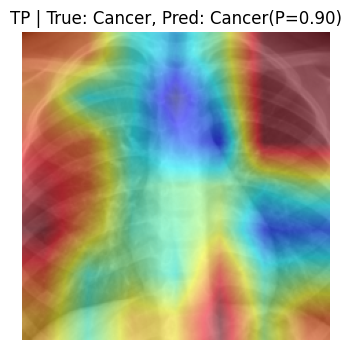

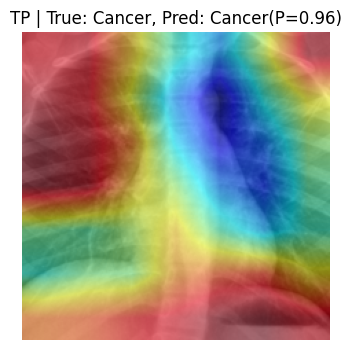


=== FP Samples ===


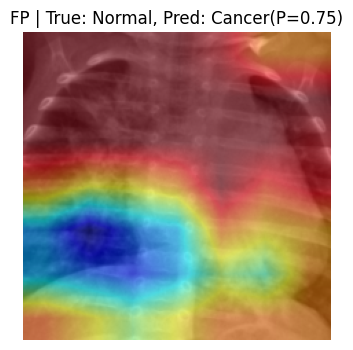

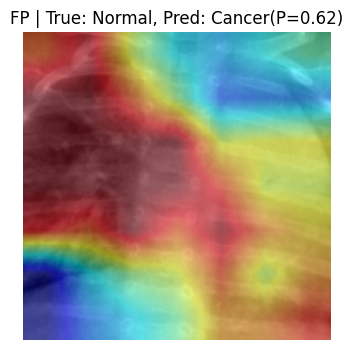


=== FN Samples ===


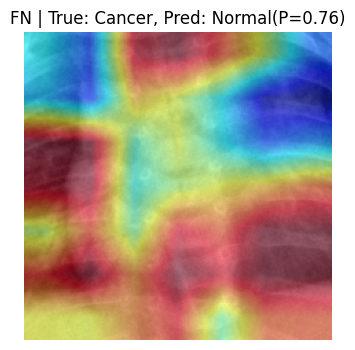

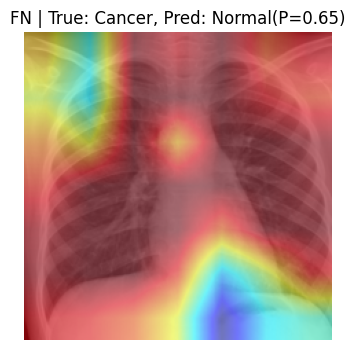


=== TN Samples ===


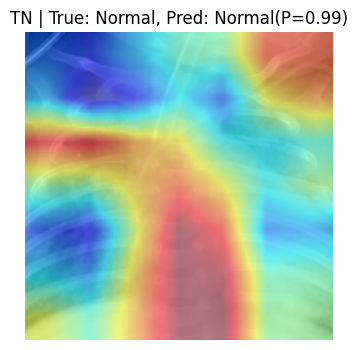

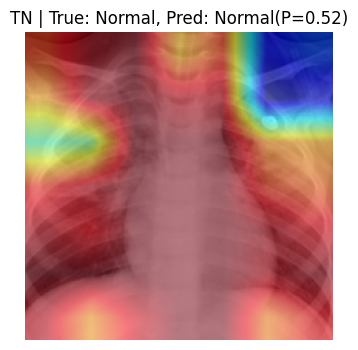

In [40]:
# Ensure eval mode
model.eval()

# Correct DenseNet target layer
target_layer = model.base_model.features.norm5

# Initialize Grad-CAM
gradcam = GradCAM(model, target_layer)

# Get categorized samples
samples = select_gradcam_samples(model, test_loader, device)

label_map = {0: "Normal", 1: "Cancer"}

# Loop through categories
for category, items in samples.items():
    print(f"\n=== {category} Samples ===")

    for idx, (img, true_label, pred_label) in enumerate(items):
        img = img.unsqueeze(0).to(device)

        # Forward pass for probability
        with torch.no_grad():
            outputs = model(img)
            probs = torch.softmax(outputs, dim=1)
            pred_prob = probs[0, pred_label].item()

        cam = gradcam.generate(img)

        title = (
            f"{category} | "
            f"True: {label_map[true_label]}, "
            f"Pred: {label_map[pred_label]}"
            f"(P={pred_prob:.2f})"
        )

        show_gradcam(img[0], cam, title)



In [41]:
# Loop through each category in the dictionary
for category, items in samples.items():
    print(f"\nSaving Grad-CAMs for category: {category}")

    for idx, (img, true_label, pred_label) in enumerate(items):
        # 1. Prepare image for the model
        image_gpu = img.unsqueeze(0).to(device)

        # 2. Generate probability for the filename (since it wasn't stored in the tuple)
        with torch.no_grad():
            outputs = model(image_gpu)
            probs = torch.softmax(outputs, dim=1)
            prob = probs[0, pred_label].item()

        # 3. Generate the CAM heatmap
        cam = gradcam.generate(image_gpu)

        # 4. Determine the save directory based on the category name
        # We use the category key (TP, FP, etc.) to set the folder name
        category_folder_map = {
            "TP": "True_Positive",
            "FP": "False_Positive",
            "FN": "False_Negative",
            "TN": "True_Negative"
        }

        folder_name = category_folder_map.get(category, category)
        save_dir = f"/content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/{folder_name}"

        # 5. Create a descriptive filename
        filename = f"img_{idx}_True{true_label}_Pred{pred_label}_Prob{prob:.2f}.png"

        # 6. Save using your existing save_gradcam function
        save_gradcam(
            image_tensor=img, # Original tensor
            cam=cam,
            save_dir=save_dir,
            filename=filename,
            alpha=0.5
        )


Saving Grad-CAMs for category: TP
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/True_Positive/img_0_True1_Pred1_Prob0.90.png
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/True_Positive/img_1_True1_Pred1_Prob0.96.png

Saving Grad-CAMs for category: FP
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/False_Positive/img_0_True0_Pred1_Prob0.75.png
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/False_Positive/img_1_True0_Pred1_Prob0.62.png

Saving Grad-CAMs for category: FN
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/False_Negative/img_0_True1_Pred0_Prob0.76.png
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/False_Negative/img_1_True1_Pred0_Prob0.65.png

Saving Grad-CAMs for category: TN
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/True_Negative/img_0_True0_Pred0_Prob0.99.png
Saved: /content/drive/MyDrive/Capstone_X-ray_Project/GradCAM/True_Negative/img_1_True0_Pred0_Prob0.52.png


In [42]:
print(model.base_model.features)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke